<h1><font color="lightblue">Učitavanje podataka i izmena naziva kolona</font></h1>

<p>U ovom delu ucitavamo podatke iz excel file-a i menjamo imena kolona kako bi bila na latinici da ne moramo da menjamo tekst za vreme kucanja</p>

In [26]:
import pandas as pd #potrebna je openpyxl biblioteka za ucitavanje excel fajlova

df = pd.read_excel("Јавни подаци о упису ИМИ.xlsx")

df = df[['Тип средње школе', 'Назив средње школе', 'Град средње школе', 'С.Ш. поени', 'П.П.']]

df.rename(columns = {
    'Тип средње школе' : 'tip',
    'Назив средње школе' : 'naziv',
    'Град средње школе' : 'grad',
    'С.Ш. поени' : 'poeniSrednja',
    'П.П.' : 'poeniPrijemni'
}, inplace = True)  
 
df   

,tip,naziv,grad,poeniSrednja,poeniPrijemni
0,Гимназија,Прва крагујевачка гимназија,Крагујевац,16.95,40
1,Техничка,Прва Теничка школа,Крагујевац,19.93,60
2,Техничка,Права Техничка школа,Крагујевац,18.25,52
3,NaN,Гимназија,Рашка,16.67,56
4,Гимназија,Пријепољска гимназија,Пријепоље,20.00,40
...,...,...,...,...,...
379,Техничка,NaN,Лепосавић,19.40,40
380,Економска,NaN,Крагујевац,18.71,48
381,Техничка,NaN,Трстеник,18.45,48
382,Гимназија,Прва крагујевачка гимназија,Крагујевац,17.15,60


<h1><font color="lightblue">Sredjivanje kolone <font color='orange'>'tip'</font></font></h1>

In [27]:

    
tipNullCount = df['tip'].isnull().sum()

print("Broj null vrednosti kolone tip:", tipNullCount)



Broj null vrednosti kolone tip: 5



<p>
Imamo 5 null vrednosti naspram 384 reda sto nije puno, ali deluje da moze da se zakljuci tip na osnovu imena srednje skole pa mozemo da koristimo to kao nacin da popunimo ove vrednosti.
</p>

In [28]:
tipovi = ['Гимназија', 'Техничка', 'Медицинска', 'Остале', 'Економска ', 'Машинскa']

#popunjavamo na vrednosti na osnovu toga da li se tip nalazi u nazivu u lowercase-u, 
#ako se ne nalazi stavljamo da je tip 'Ostale'

df['tip'].fillna(df['naziv'].apply(lambda naziv: next((tip for tip in tipovi if isinstance(naziv, str) and tip.lower() in naziv.lower()), "Остале")), inplace=True)

tipoviPojavljivanja = df['tip'].value_counts()

tipoviPojavljivanja

#df.to_excel("izlaz.xlsx")

Гимназија     229
Техничка      117
Економска      18
Остале         15
Медицинска      4
Машинска        1
Name: tip, dtype: int64

<h1><font color="lightblue">Sredjivanje kolone <font color='orange'>'naziv'</font></font></h1>

In [29]:
print("Broj NaN u koloni naziv: ",df['naziv'].isnull().sum())

Broj NaN u koloni naziv:  28


Ovde mozemo da uzmemo da napravimo dictionary od vrednosti koje postoje za grad i naziv skole, 
i onda da prodjemo ponovo kroz te vrednosti i kada nemamo naziv skole da pogledamo neki naziv iz 
dictionary-a i da izvucemo naziv skole tako, mogli bi smo i tip da proveravamo da bi bilo pravilnije 
ali iz nekog razloga se desava da to daje gore rezultate modela, moguce je da na ovaj nacin povecavamo bias
modela za pojedine nazive skola sto pravi malo bolju predikciju, ako je varijansa veca kad ukljucimo tip u proveru
model ima dosta malo podataka i losije generalizuje. Nakon te ispravke dropujemo preostale NA vrednosti jer nismo mogli da im nadjemo ime.

In [30]:
city_school_dict = {}

for index, row in df.iterrows():
    city = row['grad']
    school = row['naziv']
    
    if not pd.isnull(city) and not pd.isnull(school):
        city_school_dict[city] = school

for index, row in df.iterrows():
    city = row['grad']
    school = row['naziv']
    
    if pd.isnull(school) and not pd.isnull(city):
        if city in city_school_dict:
            df.at[index, 'naziv'] = city_school_dict[city]
            

df.dropna(subset=['naziv'], inplace=True)
df.isnull().sum()

tip              0
naziv            0
grad             0
poeniSrednja     0
poeniPrijemni    0
dtype: int64

U ovom delu, uzimamo string vrednosti iz dataseta, spustamo ih u lowercase, i brisemo navodnike iz njih, jer je pregledanjem dataseta zakljuceno da za neke iste nazive imamo slucajeve gde imamo navodnike oko imena skole a negde ne,
takodje isto vazi za velika i mala slova u nazivu skole, sto dovodi do toga da tamo gde je najmanja razlika u imenu imamo novu kategoriju gde ne bi trebali da je imamo.

In [31]:
df['naziv'] = df['naziv'].str.lower()
df['grad'] = df['grad'].str.lower()
df['tip'] = df['tip'].str.lower()
df['naziv'] = df['naziv'].str.replace('"', '')

Postoje vrednosti ispred kojih stoji #, a ne razlikuju se od vec postojecih vrednosti, sklanjamo #

In [32]:
print("Broj pre: ",df[df['naziv'].str.startswith("#")].shape[0])

df['naziv'] = df['naziv'].str.lstrip('#')

print("Broj posle: ",df[df['naziv'].str.startswith("#")].shape[0])

#df.to_excel("izlaz.xlsx")

Broj pre:  2
Broj posle:  0


Pregledanjem dataseta je zakljuceno da imamo slovne greske u nazivu Prva tehnicka skola, u sledeca 3 dela se bavimo ispravljanem tih gresaka, opet da ne bi imali razlicte kategorije za istu stvar

In [33]:
#Greska : parva tehnicka umseto prva tehnicka

print("Broj pre: ",df[df['naziv'].str.startswith("права техничка")].shape[0])

df.loc[df['naziv'].str.startswith("права техничка"), 'naziv'] = "прва техничка школа"

print("Broj posle: ",df[df['naziv'].str.startswith("права техничка")].shape[0])

Broj pre:  15
Broj posle:  0


In [34]:
#Greska: prva tenicka umesto prva tehnicka

print("Broj pre: ",df[df['naziv'].str.startswith("прва теничка")].shape[0])

df.loc[df['naziv'].str.startswith("прва теничка"), 'naziv'] = "прва техничка школа"

print("Broj posle: ",df[df['naziv'].str.startswith("прва теничка")].shape[0])

Broj pre:  31
Broj posle:  0


In [35]:
#Greska: slola umesto skola

print("Broj pre: ",df[df['naziv'].str.endswith("шлола")].shape[0])

df.loc[df['naziv'].str.endswith("шлола"), 'naziv'] = "прва техничка школа"

print("Broj posle: ",df[df['naziv'].str.endswith("шлола")].shape[0])


Broj pre:  6
Broj posle:  0


Ovde imamo slovnu gresku gde se jedno slovo ponavlja dva puta, ali ovo nece uticati na model svakako jer je samo jedan redu u pitanju

In [36]:
print("Broj pre: ",df[df['naziv'].str.startswith("меддицинска")].shape[0])

df.loc[df['naziv'].str.startswith("меддицинска"), 'naziv'] = "медицинска школа са домом уч. сестре нинковић"

print("Broj posle: ",df[df['naziv'].str.startswith("меддицинска")].shape[0])
#df.to_excel("TEST.xlsx", )

Broj pre:  1
Broj posle:  0


<h1><font color="lightblue">Sredjivanje kolone <font color='orange'>'grad'</font></font></h1>

U ovom slucaju, nemamo vise NaN vrednosti zato sto su NaN vrednosti za grad su imale takodje NaN vrednost za naziv skole
sto je dropovano u koraku sredjivanja kolone 'naziv'

In [37]:

df.isnull().sum()


tip              0
naziv            0
grad             0
poeniSrednja     0
poeniPrijemni    0
dtype: int64

<h1><font color="lightblue">Brisanje outliera</font></h1>

Za brisanje outliera je odluceno da se koristi Local Outlier Factor metod, sa kontaminacijom od 0.124 sto se pokazalo kao najbolja vrednost rucnim isprobavanjem, i ako brise oko 50 redova verovatno je da pomaze modelu da generalizuje bolje

In [38]:
from sklearn.neighbors import LocalOutlierFactor

numericalCols = ['poeniSrednja', 'poeniPrijemni']
numericalData = df[numericalCols]

local_outlier_factor = LocalOutlierFactor(contamination=0.124)

local_outlier_factor.fit(numericalData)

outliers_lof = local_outlier_factor.fit_predict(numericalData)

df.drop(df.index[outliers_lof == -1], inplace=True)

num_rows = df.shape[0]
print("Broj redova nako brisanja outliera: ",num_rows)

Broj redova nako brisanja outliera:  329


<h1><font color="lightblue">Encoding</font></h1>

Za enkodiranje kategorijskih vrednosti sam se odlucio za TargetEncoder, One Hot ne dolazi u obzir jer bi visestruko uvecao dimenzionalnost dataseta posto za nazive skola imamo veoma puno razlicitih kategorija, Label Encoder ne bi trebao da se koristi za nominalne kategorije kao sto su naziv, grad, tip, tj one koje nemaju nikav poredak izmedju kategorija, na kraju sam odabrao TargetEncoder i ako on moze izazvati problem Target Leakage-a posto on koristi vrednost koju prediktujemo kako bi enkodirao kolone i to moze da izazove overfitting.

In [39]:
from category_encoders import TargetEncoder

encoderNaziv = TargetEncoder(cols=['naziv'])

encoded = encoderNaziv.fit_transform(df['naziv'], df['poeniPrijemni'])

df['naziv_TargetEncoded'] = encoded

df.drop('naziv', axis=1, inplace=True)

df

,tip,grad,poeniSrednja,poeniPrijemni,naziv_TargetEncoded
0,гимназија,крагујевац,16.95,40,48.973592
1,техничка,крагујевац,19.93,60,40.680727
2,техничка,крагујевац,18.25,52,40.680727
3,гимназија,рашка,16.67,56,45.850545
4,гимназија,пријепоље,20.00,40,44.071833
...,...,...,...,...,...
376,гимназија,ћуприја,20.00,52,44.584272
377,техничка,ужице,16.36,24,44.702587
380,економска,крагујевац,18.71,48,48.973592
381,техничка,трстеник,18.45,48,45.286349


In [40]:

# Initialize the TargetEncoder
encoderGrad = TargetEncoder(cols=['grad'])

# Fit and transform the data
encoded = encoderGrad.fit_transform(df['grad'], df['poeniPrijemni'])

# Assign the encoded values to the DataFrame
df['grad_TargetEncoded'] = encoded

df.drop('grad', axis=1, inplace=True)

# Display the encoded DataFrame
df

,tip,poeniSrednja,poeniPrijemni,naziv_TargetEncoded,grad_TargetEncoded
0,гимназија,16.95,40,48.973592,44.882353
1,техничка,19.93,60,40.680727,44.882353
2,техничка,18.25,52,40.680727,44.882353
3,гимназија,16.67,56,45.850545,46.434120
4,гимназија,20.00,40,44.071833,43.545915
...,...,...,...,...,...
376,гимназија,20.00,52,44.584272,44.575683
377,техничка,16.36,24,44.702587,44.702587
380,економска,18.71,48,48.973592,44.882353
381,техничка,18.45,48,45.286349,44.006305


In [41]:
# Initialize the TargetEncoder
encoderTip = TargetEncoder(cols=['tip'])

# Fit and transform the data
encoded = encoderTip.fit_transform(df['tip'], df['poeniPrijemni'])

# Assign the encoded values to the DataFrame
df['tip_TargetEncoded'] = encoded

df.drop('tip', axis=1, inplace=True)

# Display the encoded DataFrame
df


,poeniSrednja,poeniPrijemni,naziv_TargetEncoded,grad_TargetEncoded,tip_TargetEncoded
0,16.95,40,48.973592,44.882353,46.948454
1,19.93,60,40.680727,44.882353,42.248114
2,18.25,52,40.680727,44.882353,42.248114
3,16.67,56,45.850545,46.434120,46.948454
4,20.00,40,44.071833,43.545915,46.948454
...,...,...,...,...,...
376,20.00,52,44.584272,44.575683,46.948454
377,16.36,24,44.702587,44.702587,42.248114
380,18.71,48,48.973592,44.882353,40.693677
381,18.45,48,45.286349,44.006305,42.248114


<h1><font color='lightblue'>Crtanje korelacione matrice</font></h1>

Poeni iz srednje imaju kolko tolko dobru korelaciju sa poenima iz srednje ali opet 0.4 i nije bas sjajna vrednost,
sve ostalo je onako, naziv ima solidnu korelaciju, bilo kako bilo, koristicemo sve kolone kao prediktore zbog malog broja
opservacija

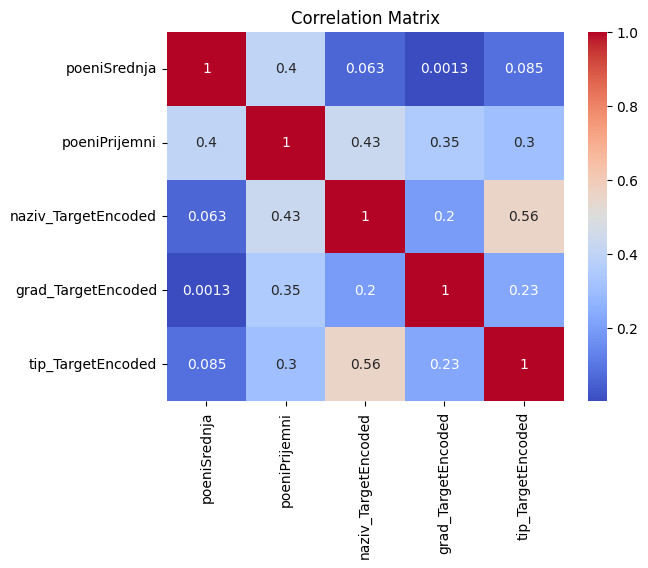

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


<h1><font color="lightblue">Deljenje skupa na train i test u odnosuu 0.8 : 0.2</font></h1>

Pored toga sto delimo skup, ovde takodje skaliramo vrednosti kolone poeniSrednja, veza izmedju poena iz srednje skole
i poena sa prijemnog i nije bas linearna tako da ovo pomaze linearnoj regresiji i skalira vrednosti poenaSrednja

In [43]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df[['poeniSrednja', 'naziv_TargetEncoded', 'grad_TargetEncoded', 'tip_TargetEncoded']]
#Ovo sluzi samo da se skloni setting with copy warning
X = X.copy()
X['poeniSrednja'] = np.sqrt(X['poeniSrednja'])

y = df['poeniPrijemni']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42 )

<h1>Funkcija za stampanje metrike modela</h1>

Funkcija koja stampa metrike regresionih modela<br>
Kao argumente prosledjuje testne i podatke koje su prediktovani na osnovu X_test

stampa:

Mean absolute error<br>
Mean sqared error<br>
Root mean squared error<br>

R2 score<br>
Adjusted R2 score (na osnovu formule posto ne postoji kao ugradjena funkcija)<br>

Adjusted R2 je relativno solidan indikator toga da li su prediktori dobri, posto
ce se obican R2 povecavati svaki put kada dodamo bilo kakav prediktor u model bez 
obzira na to da li on poboljsava objasnjavanje varijanse ili ne

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def printStats(y_test, y_pred):
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Print the regression metrics
    print("\nRegression Metrics:")
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R2-score:", r2)
   
    n = len(y_test) #Broj opservacija
    k = X.shape[1]  #Broj prediktora

    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    print("Adjusted R2:", adjusted_r2)

<h1>Prvi model - Linearna Regresija </h1>

Kao prvi model sam uzeo najprostiju linearnu regresiju na osnovu prediktora,

In [45]:
from sklearn.linear_model import LinearRegression

modelLR = LinearRegression()

modelLR.fit(X_train, y_train)

y_pred = modelLR.predict(X_test)

y_pred = modelLR.predict(X_test)

printStats(y_test, y_pred)

scores = cross_val_score(modelLR, X, y, cv=5)
print("Cross val R2 scores:")
print(scores.mean(), scores.std())




Regression Metrics:
Mean Absolute Error: 5.368331287544095
Mean Squared Error: 45.60909518838474
Root Mean Squared Error: 6.753450613455668
R2-score: 0.5157146581498538
Adjusted R2: 0.48395824229082784
Cross val R2 scores:
0.3632379300112323 0.06604904295407567


U proseku masimo 6.7 poena od prave vrednosti poena, sto nije tako lose i pored toga objasnili smo 51 posto varijanse modelom ako gledamo R2 a adjusted R2 se ne razlikuje toliko puno, svakako ovo nije nesto sto se moze nazvati dobrim modelom ali ipak je solidno naspram ostalih mogucnosti kao sto ce se i primetiti u daljem radu

<h1>Isprobavanje razlicitih modela</h1>

In [46]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor(max_iter=1000),
]

for model in models:
    model_name = model.__class__.__name__
    print("Testing", model_name)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    printStats(y_test, y_pred)

    scores = cross_val_score(model, X, y, cv=5)
    print("Cross val R2 scores:")
    print(scores.mean(), scores.std())
    
    print("--------------------------")

Testing LinearRegression

Regression Metrics:
Mean Absolute Error: 5.368331287544095
Mean Squared Error: 45.60909518838474
Root Mean Squared Error: 6.753450613455668
R2-score: 0.5157146581498538
Adjusted R2: 0.48395824229082784
Cross val R2 scores:
0.3632379300112323 0.06604904295407567
--------------------------
Testing Ridge

Regression Metrics:
Mean Absolute Error: 5.322799258345731
Mean Squared Error: 45.35707154829761
Root Mean Squared Error: 6.734765886673241
R2-score: 0.5183906891956308
Adjusted R2: 0.48680975078222954
Cross val R2 scores:
0.36123027233754323 0.05893538907716076
--------------------------
Testing Lasso

Regression Metrics:
Mean Absolute Error: 6.187145960844046
Mean Squared Error: 65.52667657169124
Root Mean Squared Error: 8.094854944450287
R2-score: 0.30422629888288066
Adjusted R2: 0.2586017938915941
Cross val R2 scores:
0.21918003105641937 0.024966014425767003
--------------------------
Testing ElasticNet

Regression Metrics:
Mean Absolute Error: 6.22044866300

Ovde nakon ovog testiranja moze da se zakljuci da jedini model koji daje malo bolje rezultate je Ridge, tj Ridge regresija koja vrsi regularizaciju prediktora, pokusacemo da ga poboljsamo u sledecem koraku tako sto cemo racunati alpha koriscenjem cross validacije


Regression Metrics:
Mean Absolute Error: 5.362708052158677
Mean Squared Error: 45.55423383205281
Root Mean Squared Error: 6.749387663488652
R2-score: 0.5162971856171459
Adjusted R2: 0.48457896828056524
Cross val scores:
0.36319374753927564 0.06523305861942015


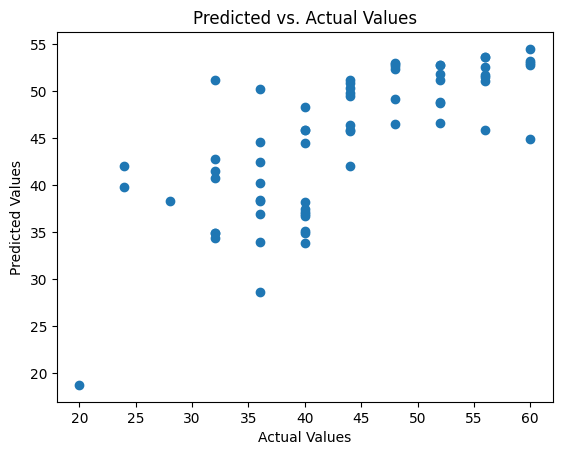

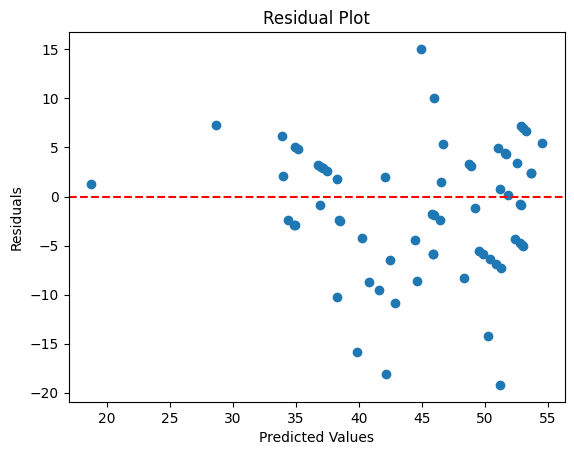

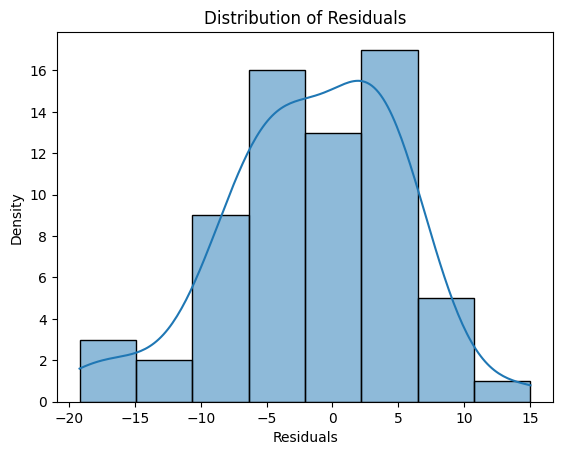

In [47]:
from sklearn.linear_model import RidgeCV

#Alpha vrednosti koje cemo koristiti da bi nasli bolje vrednosti
#RidgeCV ima ugradjenu cross validaciju koja trazi najbolje alpha
#Na 5 foldova
ridgeCV = RidgeCV(cv=5)

ridgeCV.fit(X_train, y_train)

best_alpha = ridgeCV.alpha_

ridgeBA = Ridge(alpha=best_alpha)
ridgeBA.fit(X_train, y_train)

y_pred = ridgeBA.predict(X_test)

printStats(y_test, y_pred)

scores = cross_val_score(ridgeBA, X, y, cv=5)
print("Cross val scores:")
print(scores.mean(), scores.std())


# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Density plot or histogram of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()


# Display the plot
plt.show()





Zapravo smo dobili cak malo gore vrednosti nego za defaultni Ridge, tako da cemo istrenirati samo jedan klasican Ridge model, na plotovima se moze primetiti da nam model nije bas sjajan posebno na plotu reziduala, nemamo skupljanje oko crvene linije vec su tacke razbacane svuda redom tj model gresi dosta, ali barem reziduali imaju kolko tolko normalnu raspodelu.

In [48]:
ridgeFinal = Ridge()

# Fit the model to the training data
ridgeFinal.fit(X_train, y_train)

# Predict on the test data
y_pred = ridgeFinal.predict(X_test)

printStats(y_test, y_pred)


Regression Metrics:
Mean Absolute Error: 5.322799258345731
Mean Squared Error: 45.35707154829761
Root Mean Squared Error: 6.734765886673241
R2-score: 0.5183906891956308
Adjusted R2: 0.48680975078222954


<h1>Proba CatBoost modela</h1>

Ovde je isproban CatBoost cisto zato sto je receno da je on jedno od boljih resenja

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Regression Metrics:
Mean Absolute Error: 5.765979272489953
Mean Squared Error: 60.670219732472724
Root Mean Squared Error: 7.7891090461279795
R2-score: 0.3557930061557839
Adjusted R2: 0.31354992459222875
0:	learn: 9.9355866	total: 518us	remaining: 103ms
1:	learn: 9.8021379	total: 910us	remaining: 90.2ms
2:	learn: 9.6887263	total: 1.31ms	remaining: 86ms
3:	learn: 9.5625972	total: 1.73ms	remaining: 84.9ms
4:	learn: 9.4405726	total: 2.14ms	remaining: 83.6ms
5:	learn: 9.3069306	total: 2.51ms	remaining: 81.3ms
6:	learn: 9.1856630	total: 2.89ms	remaining: 79.6ms
7:	learn: 9.0564296	total: 3.25ms	remaining: 78ms
8:	learn: 8.9506120	total: 3.61ms	remaining: 76.7ms
9:	learn: 8.8303477	total: 3.97ms	remaining: 75.4ms
10:	learn: 8.7430680	total: 4.32ms	remaining: 74.3ms
11:	learn: 8.6788193	total: 4.67ms	remaining: 73.2ms
12:	learn: 8.5923575	total: 5.09ms	remaining: 73.3ms
13:	learn: 8.5066296	total: 5.47ms	remaining: 72.6ms
14:	learn: 8.4475425	total: 5.89ms	remaining: 72.7ms
15:	learn: 8.3748

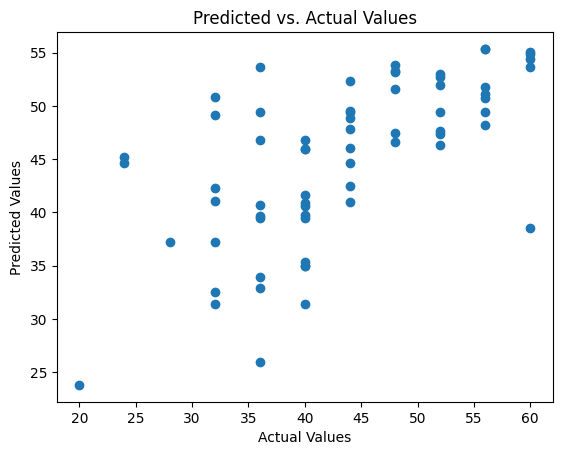

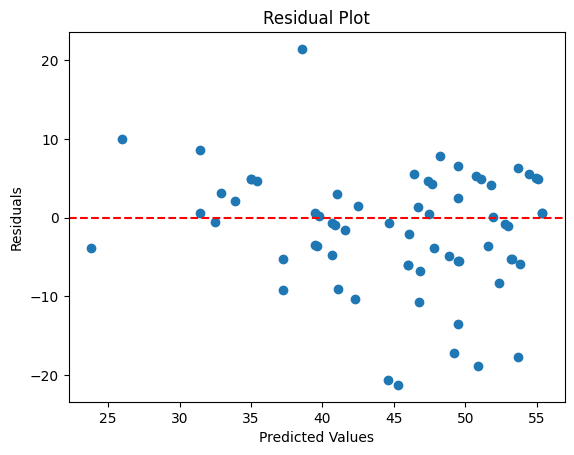

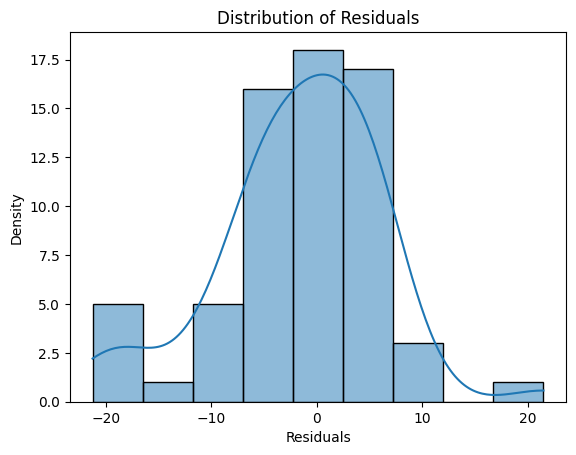

In [49]:
from catboost import CatBoostRegressor

best = CatBoostRegressor(depth = 5 , iterations= 200, learning_rate=0.05 , loss_function='RMSE')

best.fit(X_train, y_train, plot=True, verbose=False)

y_pred = best.predict(X_test)

printStats(y_test, y_pred)

scores = cross_val_score(best, X, y, cv = 5 )
print("Cross val scores:")
print(scores.mean(), scores.std())


# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Density plot or histogram of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()



CatBoost model je podesvan rucno, bez Cross Validacije nad razlicitim parametrima, dobijamo solidne rezultate, ali je model gori od obicne Ridge regresije tako da ga necemo koristiti za predvidjanje

<h1>Obrada ulaznih podataka</h1>

Ocekuje se ulaz u formi excel dokumenta koji je iste forme kao podaci koji su origalno dati za treniranje modela, dalja obrada se izvrsava automatski, postoji mogucnost unosa vise redova ako je to potrebno

Na kraju sam se odlucio za Ridge model posto je on dao najbolji R2 score i najmanje RMSE i MAE

In [50]:
input = pd.read_excel("ulaz.xlsx")

input = input[['Тип средње школе', 'Назив средње школе', 'Град средње школе', 'С.Ш. поени', 'П.П.']]

#menjamo imena kolonama kao u prvom koraku
input.rename(columns = {
    'Тип средње школе' : 'tip',
    'Назив средње школе' : 'naziv',
    'Град средње школе' : 'grad',
    'С.Ш. поени' : 'poeniSrednja',
    'П.П.' : 'poeniPrijemni'
}, inplace = True)  

#spustamo sve u lowercase, i brisemo navodnike
input['naziv'] = input['naziv'].str.lower()
input['grad'] = input['grad'].str.lower()
input['tip'] = input['tip'].str.lower()
input['naziv'] = input['naziv'].str.replace('"', '')

#encodiramo kolone
encodedNaziv = encoderNaziv.transform(input['naziv'])
input['naziv_TargetEncoded'] = encodedNaziv
input.drop('naziv', axis=1, inplace=True)

encodedGrad = encoderGrad.transform(input['grad'])
input['grad_TargetEncoded'] = encodedGrad
input.drop('grad', axis=1, inplace=True)

encodedTip = encoderTip.transform(input['tip'])
input['tip_TargetEncoded'] = encodedTip
input.drop('tip', axis=1, inplace=True)


#biramo x i y, vadimo koren iz poeniSrednja
x = input.drop("poeniPrijemni", axis=1)
x['poeniSrednja'] = np.sqrt(x['poeniSrednja'])
y = input['poeniPrijemni']

#vrsimo predikciju ridgeFinal modelom
pred = ridgeFinal.predict(x)

for i in range (len(pred)):
    print(int(pred[i]))


46
